In [12]:
#importing required packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import time
from xgboost import XGBRegressor

In [18]:
#loading the data and setting my features and target variables in the training data 
trainh = pd.read_csv('train (1).csv', sep=',')
testh = pd.read_csv('test (1).csv', sep=',')
features, target = trainh.iloc[:,:-1], trainh.iloc[:,-1]
combineddf = pd.concat([trainh, testh], axis = 0)
combineddf.index = list(range(0,2919))
combineddf

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [19]:
#creating a function to preprocess our data 
def PreProcess(combineddf):
    """
    #Keyword Arguments
    -----------------
    **Inputs**
    combineddf -- your dataframe combining training and test sets. See repository for .csv file 
    
    **Outputs**
    finaltrain -- your cleaned training dataset in .csv format 
    finaltest -- your cleaned testing dataset in .csv format
    """
    
    #splitting the combineddf into training and test sets 
    traindf = combineddf.iloc[:1460, :]
    testdf = combineddf.iloc[1460:, :]
    
    #removing GrLivArea outliers in the traindf dataset
    traindf = traindf.drop(traindf[(traindf.GrLivArea > 4500)].index)
    
    #removing LotFrontage outliers in the training dataset
    traindf = traindf.drop(traindf[(traindf.LotFrontage > 300)].index)
    
    #storing SalePrice from the training dataset as pandas Series
    global target
    target = traindf.SalePrice
    #dropping SalePrice from the training and testing datasets
    traindf = traindf.drop(['SalePrice'], axis = 1)
    testdf = testdf.drop(['SalePrice'], axis = 1)

    #concatenating training and testing datasets back together 
    fulldf = pd.concat([traindf, testdf], sort = False)  

    
    """
    
    **Imputing / Dropping variables with NA values**
    
    """
    
    #given that RL is by far the most common value in the data set with 77% of values, we can fill in missing values as RL 
    fulldf['MSZoning'] = fulldf['MSZoning'].fillna('RL')
    
    #replacing missing LotFrontage values with the mean values for each Neighborhood
    fulldf['LotFrontage'] = fulldf.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.mean())).astype(int)
    
    #NA means no alley access, so making Alley binary variable with 0 = No Alley access and 1 = Alley Access 
    fulldf['Alley'] = fulldf['Alley'].fillna('NoAlley')
    fulldf['Alley'] = fulldf['Alley'].replace({'NoAlley':0,'Grvl':1,'Pave':1})
    
    #Condition2 is 99% Norm, therefore drop
    fulldf = fulldf.drop(['Condition2'], axis = 1)
    
    #given 99% of values in Utilities are AllPub, this doesn't add much information and should therefore be dropped
    fulldf = fulldf.drop(["Utilities"], axis = 1)
    
    #filling in missing GarageYrBlt values with the same values as year built
    fulldf['GarageYrBlt'] = fulldf['GarageYrBlt'].fillna(fulldf['YearBuilt'])
    
    #dropping RoofMatl as 98% of values in full dataset are CompShg
    fulldf = fulldf.drop(['RoofMatl'], axis = 1)
    
    #imputing the one NA in both Exterior1st and Exterior2nd with the mode of each 
    fulldf['Exterior1st'] = fulldf['Exterior1st'].fillna(fulldf['Exterior1st'].mode()[0])
    fulldf['Exterior2nd'] = fulldf['Exterior2nd'].fillna(fulldf['Exterior2nd'].mode()[0])
    
    #assuming Masonry Veneer missing values mean none and imputing as None for Type and 0 for Area 
    fulldf['MasVnrType'] = fulldf['MasVnrType'].fillna('None')
    fulldf['MasVnrArea'] = fulldf['MasVnrArea'].fillna(0)
    
    #basement variables with NA mean no basement, replace with None 
    for x in ['BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtExposure']:
        fulldf[x] = fulldf[x].fillna('None')
        
    #imputing the one missing values in BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, variables as 0, likely means no basement 
    fulldf['BsmtFinSF1'] = fulldf['BsmtFinSF1'].fillna(0)
    fulldf['BsmtFinSF2'] = fulldf['BsmtFinSF2'].fillna(0)
    fulldf['BsmtUnfSF'] = fulldf['BsmtUnfSF'].fillna(0)
    fulldf['TotalBsmtSF'] = fulldf['TotalBsmtSF'].fillna(0)
    
    #imputing missing value in the Electrical column as the mode
    fulldf['Electrical'] = fulldf['Electrical'].fillna(fulldf['Electrical'].mode()[0])
    
    #dropping LowQualFinSF variable given 99% of values are 0
    fulldf = fulldf.drop(['LowQualFinSF'], axis = 1)
    
    #imputing BsmtHalfBath and BsmtFullBath NA's as 0 
    for x in ['BsmtHalfBath','BsmtFullBath']:
        fulldf[x] = fulldf[x].fillna(0)
        
    #imputing the one missing value in KitchenQual as the mode
    fulldf['KitchenQual'] = fulldf['KitchenQual'].fillna(fulldf.KitchenQual.mode()[0])
    
    #imputing the two missing values in Functional as the mode
    fulldf['Functional'] = fulldf['Functional'].fillna(fulldf.Functional.mode()[0])
    
    #imputing NA values as Nonee in FireplaceQual variable 
    fulldf['FireplaceQu'] = fulldf['FireplaceQu'].fillna('None')
    
    #filling in the NA values as 'None' for GarageType, GarageFinish and GarageQual
    fulldf['GarageType'] = fulldf['GarageType'].fillna('None')
    fulldf['GarageFinish'] = fulldf['GarageFinish'].fillna('None')
    fulldf['GarageQual'] = fulldf['GarageQual'].fillna('None')

    #filling in missing GarageCars and GarageArea values as 0 
    fulldf['GarageCars'] = fulldf['GarageCars'].fillna(0)
    fulldf['GarageArea'] = fulldf['GarageArea'].fillna(0)

    #filling in missing GarageCond values as 0 
    fulldf['GarageCond'] = fulldf['GarageCond'].fillna('None')
    
    #filling in missing PoolQC values as 0 as NA = 'None' per documentation
    fulldf['PoolQC'] = fulldf['PoolQC'].fillna('None')
    
    #filling in missing Fence values as 0 as NA = 'None' per documentation
    fulldf['Fence'] = fulldf['Fence'].fillna('None')
    
    #dropping MiscVal column
    fulldf = fulldf.drop(['MiscVal'], axis = 1)
    
    #imputing the one missing value in SaleType as the mode
    fulldf['SaleType'] = fulldf['SaleType'].fillna(fulldf.SaleType.mode()[0])

    
    """
    
    **Dummifying qualitative variables**
    
    """
    
    #creating new variable Is_Newer_SubClss capturing age using the MSSubClass variable 
    fulldf['Is_Newer_SubClass'] = fulldf['MSSubClass'].replace({20:1, 30:0, 40:0, 45:0, 50:0, 60:1, 70:0, 75:0, 80:0, 85:0, 90:0, 120:1, 150:0, 160:1, 180:0, 190:0})
        
    #converting MSSubClass variable to string for dummification later one 
    fulldf['MSSubClass'] = fulldf['MSSubClass'].astype(str)
    
    fulldf['LotShape'] = fulldf['LotShape'].replace({'Reg': 1, 'IR1': 0, 'IR2':0, 'IR3':0})
    
    #given 95% of LandSlope variables are for 'Gentle' slope, create 0/1 dummy variable for gentle vs non-gentle slopes
    fulldf['Is_Slope_Gentle'] = (fulldf["LandSlope"] == "Gtl") * 1
    fulldf = fulldf.drop(['LandSlope'], axis = 1)
    
    #creating a TotalArea variable based on other square footage variables in dataset 
    property_area_cols = ['LotArea','TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    fulldf["TotalArea"] = fulldf[property_area_cols].sum(axis=1)
    
    #creating a proximity to railroad variable from Condition1 values
    railroad_list = ['RRNn', 'RRAn', 'RRNe', 'RRAe']
    fulldf['RR_Proximity'] = fulldf['Condition1'].apply(lambda x: 1 if x in railroad_list else 0)
    
    #creating new age variable to capture age of house at the time it was sold 
    fulldf['Age'] = fulldf['YrSold'] - fulldf['YearBuilt']
    
    #creating dummy variable to capture if a house was sold in the year it was built 
    fulldf['YearSoldYearBuilt'] = (fulldf['YearBuilt'] == fulldf['YrSold']) * 1
    
    #creating variable of square of year built
    fulldf['SqYearBuilt'] = fulldf['YearBuilt'] ** 2
    
    #creating a variable capturing a remodeling 
    fulldf['Remodeled'] = (fulldf['YearBuilt'] != fulldf['YearRemodAdd']) * 1
    
    #creating binary variable == 1 if YearRemodAdd == YrSold
    fulldf["RecentRemodel"] = (fulldf["YearRemodAdd"] == fulldf["YrSold"]) * 1

    #creating continuous variable YearsSinceRemodel capturing difference between YrSold and YearRemodAdd
    fulldf["YearsSinceRemodel"] = fulldf["YrSold"] - fulldf["YearRemodAdd"]
    
    #transforming ExterQual variable to take on ints for qualitative values 
    qual_dict_ext = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
    fulldf['ExterQual'] = fulldf['ExterQual'].replace(qual_dict_ext)
    fulldf['ExterCond'] = fulldf['ExterCond'].replace(qual_dict_ext)
    
    #transforming BsmtQual and BsmtCond variables to take on ints for qualitative values 
    qual_dict1 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    fulldf['BsmtQual'] = fulldf['BsmtQual'].replace(qual_dict1)
    fulldf['BsmtCond'] = fulldf['BsmtCond'].replace(qual_dict1)
    
    #transforming BsmtExposure to convert qualitative to numeric 
    qual_dict_bsmt2 = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
    fulldf['BsmtExposure'] = fulldf['BsmtExposure'].replace(qual_dict_bsmt2)
    
    #transforming BsmtFinType1 & BsmtFinType2 to convert qualitative values to numeric 
    qual_dict_bsmt3 = {'None': 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    fulldf['BsmtFinType1'] = fulldf['BsmtFinType1'].replace(qual_dict_bsmt3)
    fulldf['BsmtFinType2'] = fulldf['BsmtFinType2'].replace(qual_dict_bsmt3)
    
    #mapping HeatingQC qualitative values to numeric
    fulldf['HeatingQC'] = fulldf['HeatingQC'].replace(qual_dict1)
    
    #making CentralAir variable binary
    fulldf['CentralAir'] = (fulldf['CentralAir'] == 'Y') * 1
    
    #making Has2ndFloor variable if house has a 2nd floor 
    fulldf['Has2ndFloor'] = (fulldf['2ndFlrSF'] > 0) * 1
    
    #creating 1st + 2nd Total livable area variable
    fulldf['Area1st2nd'] = fulldf['1stFlrSF'] + fulldf['2ndFlrSF']
    
    #mapping KitchenQual variable 
    fulldf['KitchenQual'] = fulldf['KitchenQual'].replace(qual_dict1)
    
    #creating a new Has_Pool 0/1 variable 
    fulldf['PoolArea'] = fulldf['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    fulldf.rename(columns={'PoolArea': 'Has_Pool'}, inplace=True)
    
    #mapping Functinal variable to convert to int values 
    fulldf["Functional"] = fulldf["Functional"].map({None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)
    
    #creating HasFireplace boolean if Fireplaces > 0
    fulldf['HasFireplace'] = (fulldf['Fireplaces'] > 0) * 1

    #mapping FireplaceQual variable 
    fulldf['FireplaceQu'] = fulldf['FireplaceQu'].replace(qual_dict1)
    
    #mapping GarageQual variable to make it ordinal
    fulldf['GarageQual'] = fulldf['GarageQual'].replace(qual_dict1)
    
    #mapping GarageCond variable to make it ordinal
    fulldf['GarageCond'] = fulldf['GarageCond'].replace(qual_dict1)
    
    #creating HasWoodDeck variable if house has a wood deck
    fulldf["HasWoodDeck"] = (fulldf["WoodDeckSF"] > 0) * 1
    
    #creating HasOpenPorch variable if house has an open porch 
    fulldf["HasEnclosedPorch"] = (fulldf["EnclosedPorch"] > 0) * 1

    #creating Has3snPorch variable if house has a three season porch 
    fulldf["Has3SsnPorch"] = (fulldf["3SsnPorch"] > 0) * 1
    
    #creating HasScreenporch variable if house has a screen porch 
    fulldf["HasScreenPorch"] = (fulldf["ScreenPorch"] > 0) * 1
    
    #mapping PoolQC variable to make it ordinal
    fulldf['PoolQC'] = fulldf['PoolQC'].replace(qual_dict1)
    
    #mapping Fence variable
    fulldf["Fence"] = fulldf["Fence"].map({'None': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    #creating a binary HasShed variable
    fulldf["HasShed"] = (fulldf["MiscFeature"] == "Shed") * 1
    
    #converting MoSold to str to allow for dummification later on 
    fulldf['MoSold'] = fulldf['MoSold'].astype(str)
    
    
    #getting dummies for all other variables 
    fulldf = pd.get_dummies(fulldf, drop_first = True)
    
    
#     print(fulldf.loc[:, fulldf.isna().any()])

    
    """
    
    **Removing certain variables that would cause overfitting**
    
    """
    
    #dropping the dummified railroad variables as RR_Proximity variables already captures this information
    fulldf = fulldf.drop(['Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn','Id'], axis = 1)
        
    global df2 
    df2 = fulldf
    

    print(fulldf)
#     return list(filter(lambda x: x[0:2] == 'Sa', list(fulldf.columns)))

    
PreProcess(combineddf)

      LotFrontage  LotArea  Alley  LotShape  OverallQual  OverallCond  \
0              65     8450      0         1            7            5   
1              80     9600      0         1            6            8   
2              68    11250      0         0            7            5   
3              60     9550      0         0            7            5   
4              84    14260      0         0            8            5   
...           ...      ...    ...       ...          ...          ...   
2914           21     1936      0         1            4            7   
2915           21     1894      0         1            4            5   
2916          160    20000      0         1            5            7   
2917           62    10441      0         1            5            5   
2918           74     9627      0         1            7            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  SaleType_ConLI  \
0          2003          2003       196.0     

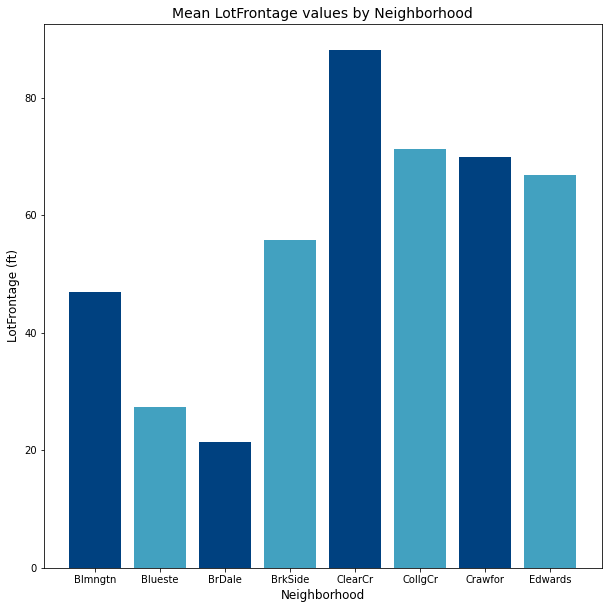

In [55]:
#creating EDA for our LotFrontage / Neighborhood variables

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand
 
data = [2, 3]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
 
# Get a color map
my_cmap = cm.get_cmap('ocean')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=4)
 
ax.bar(df5.index[:8], df5['LotFrontage'][:8], color=my_cmap(my_norm(data)))
ax.set_xlabel("Neighborhood", fontsize = 12)
ax.set_ylabel("LotFrontage (ft)", fontsize = 12)
ax.set_title("Mean LotFrontage values by Neighborhood", fontsize = 14)
plt.show()

In [6]:
#creating our new train and test sets 
df2train = df2[0:1457]
df2test = df2[1457:]
df2train_withtarget = pd.concat([df2train, target], axis = 1)
df2train.shape, target.shape, df2train_withtarget.shape

((1457, 223), (1457,), (1457, 224))

In [9]:
#creating a class that tests different positive correlation cutoff values to perform feature selection

class Feature_Select(object):
    
    def __init__(self):
        self.target = None
        self.trainingdf = None
        self.testingdf = None
        self.trainingsubset = None 
        self.testingsubset = None
        self.poscorrinterval = np.linspace(0,.7,15)
        self.negcutoff = -0.1
        self.model = None
        self.models = ['Ridge', 'Lasso', 'GradientBoostingRegressor', 'RandomForestRegressor', 'XGBoost']
        self.resultsdict1 = {}
        self.resultsdict2 = {}
    
    #loops through different cutoff values and cross-validates the feature subsets using 3 folds, then ranks the algorithms with the best RMSE testing scores
    def feature_selector(self, X, X1, X2, poscorrinterval):  #X is df2train_withtarget, X1 is df2train, X2 is df2test
        self.target = X.iloc[:1457, -1]
        print(self.target)
        self.trainingdf = X1
        self.testingdf = X2
        #looking at last correlation matrix column with SalePrice
        corrmatrix = X.corr().iloc[:,-1]
        for model in self.models:
            self.set_model(model)
            for i in poscorrinterval:
                featurenames = []
                for idx, x in enumerate(corrmatrix): 
                    #checks if the correlation value is greater than the cutoff value
                    if (x > i) or (x < self.negcutoff):
                        featurenames.append(X.columns[idx])
                    else:
                        continue 
                featurenames = list(filter(lambda x: x != 'SalePrice', featurenames))
                score = np.mean(cross_val_score(self.model, self.trainingdf[featurenames], self.target, cv=3, scoring = 'neg_mean_squared_error'))
                key2 = str(model) + ' Cross Val ' + str(len(featurenames))
                self.resultsdict2[key2] = score
            score2 = np.mean(cross_val_score(self.model, self.trainingdf, self.target, cv=3, scoring = 'neg_mean_squared_error'))
            key1 = str(model) + ' All Vars'
            self.resultsdict2[key1] = score2
        #sorts the models by RMSE
        return sorted(self.resultsdict2.items(), key = lambda x: x[0], reverse = True)
                        
    #instantiates new models                   
    def set_model(self, *args):
        if 'Ridge' in args:
            self.model = Ridge()
        elif 'Lasso' in args: 
            self.model = Lasso() 
        elif 'GradientBoostingRegressor' in args:
            self.model = GradientBoostingRegressor()
        elif 'RandomForestRegressor' in args:
            self.model = RandomForestRegressor()
        elif 'XGBoost' in args:
            self.model = XGBRegressor()
        else:
            print("Please choose one of the supported sklearn Regressor objects")
        
        
t1 = Feature_Select()
t1.feature_selector(df2train_withtarget, df2train, df2test, np.linspace(0,.6,5))

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1457, dtype: float64


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241198599534.93597, tolerance: 623306765.1434141
  positive)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216645423274.8228, tolerance: 590479145.3204185
  positive)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231659567788.34604, tolerance: 626679783.5877521
  positive)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceW

[('XGBoost Cross Val 99', -712090111.921571),
 ('XGBoost Cross Val 79', -719001249.7573601),
 ('XGBoost Cross Val 59', -823540815.2281107),
 ('XGBoost Cross Val 47', -863321343.0916348),
 ('XGBoost Cross Val 151', -686769397.888547),
 ('XGBoost All Vars', -697994670.8214737),
 ('Ridge Cross Val 99', -766499945.0803665),
 ('Ridge Cross Val 79', -798263979.0124053),
 ('Ridge Cross Val 59', -985546015.8872681),
 ('Ridge Cross Val 47', -1028030757.2071692),
 ('Ridge Cross Val 151', -779166918.7181944),
 ('Ridge All Vars', -769943110.2161627),
 ('RandomForestRegressor Cross Val 99', -731675494.6721363),
 ('RandomForestRegressor Cross Val 79', -741253184.1792192),
 ('RandomForestRegressor Cross Val 59', -807666911.1024642),
 ('RandomForestRegressor Cross Val 47', -829896928.1625293),
 ('RandomForestRegressor Cross Val 151', -728376213.3698589),
 ('RandomForestRegressor All Vars', -713962889.6268953),
 ('Lasso Cross Val 99', -780292562.921919),
 ('Lasso Cross Val 79', -809265871.2029091),
 ('

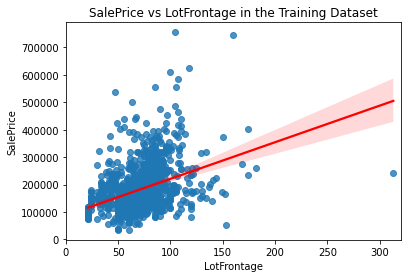

In [178]:
#finding outliers by LotFrontage in the training dataset
import seaborn as sns
ax1 = sns.regplot(x=trainh2['LotFrontage'], y = trainh2['SalePrice'], data=trainh2, fit_reg=True, line_kws={"color": "red"}) 
ax1.set(xlabel='LotFrontage', ylabel='SalePrice', title = 'SalePrice vs LotFrontage in the Training Dataset') 
plt.xlim(0,320)
plt.show()

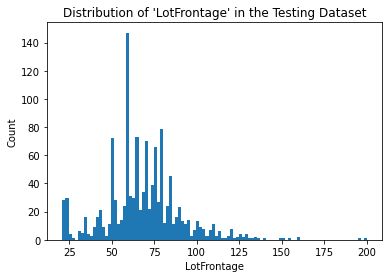

In [180]:
#looking at distribution of the testing data LotFrontage to check for potential outliers
plt.hist(combineddf['LotFrontage'][1460:], 100)
plt.xlabel('LotFrontage')
plt.ylabel('Count')
plt.title('Distribution of \'LotFrontage\' in the Testing Dataset')
plt.show()

In [249]:
#based on low dispersion of lot frontage valuees in the same neighborhoods, taking the mean for each makes sense 
fulldf.groupby('Neighborhood').agg({'LotFrontage':['mean','std','median']})

LotFrontage                  
                    mean        std median
Neighborhood                              
Blmngtn        46.900000   4.919350   43.0
Blueste        27.300000   5.313505   24.0
BrDale         21.500000   1.137147   21.0
BrkSide        55.789474  12.722818   51.0
ClearCr        88.150000  22.628057   80.5
CollgCr        71.336364  15.940401   70.0
Crawfor        69.951807  19.141262   70.0
Edwards        65.153409  18.207825   64.5
Gilbert        74.207207  28.386654   64.0
IDOTRR         62.241379  15.454333   60.0
MeadowV        25.606061   8.521808   21.0
Mitchel        75.144444  26.794499   74.0
NAmes          74.574866  15.381424   73.0
NPkVill        28.142857  10.398489   24.0
NWAmes         81.517647  12.156335   80.0
NoRidge        91.629630  21.990818   89.0
NridgHt        84.184049  26.685697   92.0
OldTown        61.777293  15.642896   60.0
SWISU          59.068182   9.912167   60.0
Sawyer         74.551020  15.165154   72.0
SawyerW        70.669811  14.384331   67.0
Somerst        64.549383  23.984740   72.5
StoneBr        62.173913  21.696189   60.0
Timber         81.157895  23.202362   82.0
Veenker        72.000000  28.637970   80.0

(array([ 5.,  0.,  5.,  6.,  6.,  7., 32., 29., 23., 35., 59., 67., 73.,
        92., 89., 91., 62., 60., 57., 73., 67., 54., 45., 33., 30., 31.,
        31., 33., 26., 23., 17., 19., 18., 18., 14., 11.,  5.,  8., 13.,
        12., 10.,  6.,  6.,  5.,  1.,  3.,  5.,  6.,  5.,  4.,  3.,  2.,
         3.,  1.,  3.,  1.,  2.,  2.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 34900.,  42101.,  49302.,  56503.,  63704.,  70905.,  78106.,
         85307.,  92508.,  99709., 106910., 114111., 121312., 128513.,
        135714., 142915., 150116., 157317., 164518., 171719., 178920.,
        186121., 193322., 200523., 207724., 214925., 222126., 229327.,
        236528., 243729., 250930., 258131., 265332., 272533., 279734.,
        286935., 294136., 301337., 308538., 315739., 322940., 330141.,
        

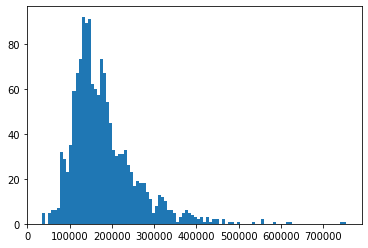

In [102]:
#looking at the distribution of the SalePrice dependent variables in the training dataset 
plt.hist(combineddf['SalePrice'][0:1460], 100)

In [103]:
#looking at which variables exhibit the highest correlation with our SalePrice dependent variable
combineddf.corr().iloc[:1460,-1].sort_values()[-5:]

GarageArea     0.623431
GarageCars     0.640409
GrLivArea      0.708624
OverallQual    0.790982
SalePrice      1.000000
Name: SalePrice, dtype: float64

combineddf['GrLivArea']

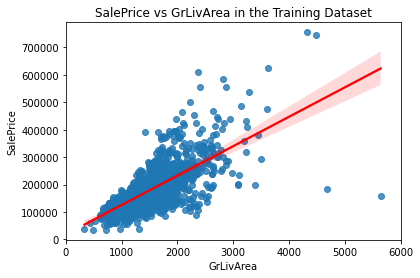

In [89]:
#using seaborn with a regression line to visualize the outliers in our training data
import seaborn as sns
#plotting GrLiv Area vs SalePrice for the training data 
ax1 = sns.regplot(x=combineddf['GrLivArea'][0:1460],y=combineddf['SalePrice'][0:1460],data=combineddf, fit_reg=True, line_kws={"color": "red"}) 
ax1.set(xlabel='GrLivArea', ylabel='SalePrice', title = 'SalePrice vs GrLivArea in the Training Dataset') 
plt.xlim(0,6000)
plt.show()

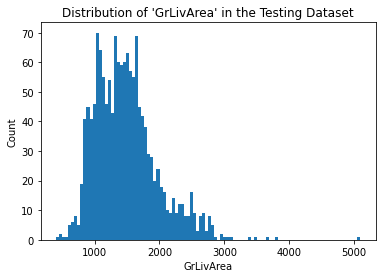

In [84]:
#looking at distribution of the testing GrLivArea to check for potential outliers
plt.hist(combineddf['GrLivArea'][1460:], 100)
plt.xlabel('GrLivArea')
plt.ylabel('Count')
plt.title('Distribution of \'GrLivArea\' in the Testing Dataset')
plt.show()

In [580]:
class Feature_Prep(object):
    
    def __init__(self):
        self.featuredict = {}
        self.objectlist = []
        self.numlist = []
        self.df1 = pd.DataFrame(np.repeat(0,1460))
        self.trainingdf = None
        self.testingdf = None
        self.dict1 = {}
        self.trainingsubset = None
        self.testingsubset = None
        self.model = None 
        self.x_train = None          
        self.x_test = None           
        self.y_train = None          #y_train of target
        self.y_test = None           #y_test of target
        self.target = None
        self.models = ['Ridge', 'Lasso', 'ElasticNet', 'BayesianRidge', 'HuberRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor']
        self.results_dict1 = {}
        self.results_dict2 = {}
        self.feature_name_list = []
        self.dict_ridge = {}
        self.dict_lasso = {}
        self.dict_elasticnet = {}
        self.dict_bayesianridge = {}
        self.dict_huberregressor = {}
        self.dict_adaboost = {}
        self.dict_gradientboosting = {}
        self.dict_randomforest = {}
        self.masterlist = []
        
    def type_filter(self, X):    #X is your trainh dataset
        for idx, x in enumerate(X.dtypes):
            self.featuredict[X.columns[idx]] = x 
        for i in list(filter(lambda x: x[1] == 'O', self.featuredict.items())):
            self.objectlist.append(i[0])
        return self.objectlist
    
    
            
    def dummify(self, X, model, posinterval, negcutoff):       #X is your combineddf dataset
        self.target = X.iloc[0:1460, -1]
        self.type_filter(X)
        for feature in self.objectlist:
            self.df1 = pd.concat([self.df1, pd.get_dummies(X[feature], prefix = feature, drop_first=True)], axis = 1)
        for i in list(filter(lambda x: x[1] == 'int64' or x[1] == 'float64', self.featuredict.items())):
            try:
                self.df1 = pd.concat([self.df1, X[i[0]]], axis = 1)
            except:
                continue
        self.trainingdf = self.df1.iloc[0:1460,1:]
        self.testingdf = self.df1.iloc[1460:,1:-1]
        self.trainingdf = self.trainingdf.fillna(self.trainingdf.mean())
        self.testingdf = self.testingdf.fillna(self.testingdf.mean())
        
        self.trainingdf.to_csv('dummifiedtrainingdf.csv',sep=',')
        self.testingdf.to_csv('dummifiedtestingdf.csv',sep=',')
        
        #running through the different models to select the best poscutoff for each 
#         for model in self.models:
#             self.set_model(model)
#             for cutoff in posinterval:
#                 dict1 = {}
#                 for idx, i in enumerate(self.trainingdf.corr().iloc[:,-1]):
#                     if i > cutoff or i < negcutoff:
#                         dict1[self.trainingdf.columns[idx]] = i
#                     else:
#                         continue
#                 self.feature_name_list = [x[0] for x in dict1.items() if x[0] != 'SalePrice']
#                 self.trainingsubset = self.trainingdf[self.feature_name_list]
#                 self.testingsubset = self.testingdf[self.feature_name_list]

#                 self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.trainingsubset, self.target, test_size = 0.2, random_state = 42)

#                 self.model.fit(self.x_train, self.y_train)
#                 key1 = model + ' ' + str(len(self.feature_name_list))
#                 self.results_dict1[key1] = (np.round(self.model.score(self.x_train, self.y_train),4), np.round(self.model.score(self.x_test, self.y_test),4), model, len(self.feature_name_list), np.round(cutoff,2))
        
#         print(len(self.results_dict1))
#         return sorted(self.results_dict1.items(), key = lambda x: (x[1][2],x[1][1]), reverse = True)
        
#         #end here
    
#         for k, v in self.results_dict1.items():
#             if k[0:5] == 'Ridge':
#                 try:
#                     self.dict_ridge[k] = v 
#                 except:
#                     continue
#             if k[0:5] == 'Lasso':
#                 try:
#                     self.dict_lasso[k] = v  
#                 except:
#                     continue
#             if k[0:10] == 'ElasticNet':
#                 try:
#                     self.dict_elasticnet[k] = v
#                 except:
#                     continue
#             if k[0:14] == 'HuberRegressor':
#                 try:
#                     self.dict_huberregressor[k] = v
#                 except:
#                     continue
#             if k[0:13] == 'BayesianRidge':
#                 try:
#                     self.dict_bayesianridge[k] = v
#                 except:
#                     continue
#             if k[0:17] == 'AdaBoostRegressor':
#                 try:
#                     self.dict_adaboost[k] = v
#                 except:
#                     continue
#             if k[0:25] == 'GradientBoostingRegressor':
#                 try:
#                     self.dict_gradientboosting[k] = v
#                 except:
#                     continue
#             if k[0:21] == 'RandomForestRegressor':
#                 try:
#                     self.dict_randomforest[k] == v
#                 except:
#                     continue
                
#         self.dict_ridge = dict(sorted(self.dict_ridge.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_lasso = dict(sorted(self.dict_lasso.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_elasticnet = dict(sorted(self.dict_elasticnet.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_huberregressor = dict(sorted(self.dict_huberregressor.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_bayesianridge = dict(sorted(self.dict_bayesianridge.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_adaboost = dict(sorted(self.dict_adaboost.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_gradientboosting = dict(sorted(self.dict_gradientboosting.items(), key = lambda x: x[1][1], reverse = True))
#         self.dict_randomforest = dict(sorted(self.dict_randomforest.items(), key = lambda x: x[1][1], reverse = True))
        
    def best_features(self, X, model, posinterval, negcutoff):
        for i in range(0,4):
            self.dummify(X, model, posinterval, negcutoff)
            self.masterlist.append(dict(list(self.dict_ridge.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_lasso.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_elasticnet.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_huberregressor.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_bayesianridge.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_adaboost.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_gradientboosting.items())[0:1]))
            self.masterlist.append(dict(list(self.dict_randomforest.items())[0:1]))
        print(self.masterlist)
        pass

#                 print(sorted(self.dict_ridge.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_lasso.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_elasticnet.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_huberregressor.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_bayesianridge.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_adaboost.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_gradientboosting.items(), key = lambda x: x[1][1], reverse = True))
#                 print(sorted(self.dict_randomforest.items(), key = lambda x: x[1][1], reverse = True))

#                 [('GradientBoostingRegressor 23 0.5 -0.2', (0.9843, 0.9029)), ('GradientBoostingRegressor 65 0.15 -0.2', (0.992, 0.9006)), ('GradientBoostingRegressor 78 0.1 -0.2', (0.9926, 0.8972)), ('GradientBoostingRegressor 28 0.45 -0.2', (0.9858, 0.8956)), ('GradientBoostingRegressor 30 0.4 -0.2', (0.9867, 0.8954)), ('GradientBoostingRegressor 128 0.0 -0.2', (0.9925, 0.8928)), ('GradientBoostingRegressor 87 0.05 -0.2', (0.9926, 0.8927)), ('GradientBoostingRegressor 19 0.6 -0.2', (0.9808, 0.8924)), ('GradientBoostingRegressor 49 0.25 -0.2', (0.9914, 0.8916)), ('GradientBoostingRegressor 20 0.55 -0.2', (0.9809, 0.8916)), ('GradientBoostingRegressor 60 0.2 -0.2', (0.9923, 0.8911)), ('GradientBoostingRegressor 45 0.3 -0.2', (0.9909, 0.8861)), ('GradientBoostingRegressor 33 0.35 -0.2', (0.9886, 0.8817)), ('GradientBoostingRegressor 15 0.7 -0.2', (0.9574, 0.8696)), ('GradientBoostingRegressor 15 0.65 -0.2', (0.9574, 0.8691))]
        
#         self.results_dict2[list(filter(lambda x: x[0][0:5] == 'Ridge', self.results_dict1.items()))[0] = sorted(list(filter(lambda x: x[0][0:5] == 'Ridge', self.results_dict1.items())))
#         self.results_dict2[list(filter(lambda x: x[0][0:5] == 'Lasso', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:5] == 'Lasso', self.results_dict1.items()))[:1][0][1]
#         self.results_dict2[list(filter(lambda x: x[0][0:10] == 'ElasticNet', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:10] == 'ElasticNet', self.results_dict1.items()))[:1][0][1]
#         self.results_dict2[list(filter(lambda x: x[0][0:14] == 'HuberRegressor', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:14] == 'HuberRegressor', self.results_dict1.items()))[:1][0][1]
#         self.results_dict2[list(filter(lambda x: x[0][0:13] == 'BayesianRidge', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:13] == 'BayesianRidge', self.results_dict1.items()))[:1][0][1]
#         self.results_dict2[list(filter(lambda x: x[0][0:17] == 'AdaBoostRegressor', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:17] == 'AdaBoostRegressor', self.results_dict1.items()))[:1][0][1]
#         self.results_dict2[list(filter(lambda x: x[0][0:25] == 'GradientBoostingRegressor', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:25] == 'GradientBoostingRegressor', self.results_dict1.items()))[:1][0][1]
#         self.results_dict2[list(filter(lambda x: x[0][0:21] == 'RandomForestRegressor', self.results_dict1.items()))[:1][0][0]] = list(filter(lambda x: x[0][0:21] == 'RandomForestRegressor', self.results_dict1.items()))[:1][0][1]
#         print(self.results_dict2)
        
#         print(list(filter(lambda x: x[0][0:5] == 'Ridge', self.results_dict1.items())))
    
    def set_model(self, *args):
        if 'Ridge' in args:
            self.model = Ridge(max_iter = 500)
        elif 'Lasso' in args: 
            self.model = Lasso(max_iter = 500) 
        elif 'ElasticNet' in args:
            self.model = ElasticNet(max_iter = 500)
        elif 'HuberRegressor' in args:
            self.model = HuberRegressor(max_iter = 500)
        elif 'BayesianRidge' in args:
            self.model = BayesianRidge(n_iter = 500)
        elif 'AdaBoostRegressor' in args:
            self.model = AdaBoostRegressor()
        elif 'GradientBoostingRegressor' in args:
            self.model = GradientBoostingRegressor(n_estimators = 500)
        elif 'RandomForestRegressor' in args:
            self.model = RandomForestRegressor(n_estimators = 500)
        else:
            print("Please choose one of the supported sklearn Regressor objects")
       

f1 = Feature_Prep()
f1.dummify(combineddf, 'GradientBoostingRegressor', np.linspace(0,0.7,15), -0.2)
# f1.best_features(combineddf, 'GradientBoostingRegressor', np.linspace(0,0.7,15), -0.2)
        

In [40]:
#deprecated class - do not use
#child class of Feature_Prep
#fitcheck method allows to select feature subsets and fits these with different models provided in self.models 
class FeatureSelection(Feature_Prep): 

    def __init__(self):
        super().__init__()
        self.poscutoff = 0.5
        self.negcutoff = -0.5
        self.featurenames = None
        self.model = Ridge()
        self.models = ['Ridge', 'Lasso', 'ElasticNet', 'BayesianRidge', 'DecisionTreeRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor']
        self.trainsubset = None      #trainhsubset                     #is there a better way to initialize these self attributes?
        self.testsubset = None       #testhsubset
        self.testpredictions = None
        self.x_train = None          #x_train of trainhsubset
        self.x_test = None           #x_test of trainhsubset
        self.y_train = None          #y_train of target
        self.y_test = None           #y_test of target
        self.localtime = time.asctime( time.localtime(time.time()) )
        self.resultsdict = {}
        self.resultsdict1 = {}
        self.poscorrinterval = list(np.linspace(0,.75,10))
    
  
    def find_features(self, X, poscutoff, negcutoff):    #X is your df2
        self.dummify(X)
        self.poscutoff = poscutoff
        self.negcutoff = negcutoff
        X0 = self.trainingdf.corr().iloc[:,-1]
        dict1 = {}
        for idx, i in enumerate(X0): 
            if i > poscutoff:
                dict1[X0.index[idx]] = i
            elif i < negcutoff:
                dict1[X0.index[idx]] = i
            else: 
                continue
        self.featurenames = [x[0] for x in list(filter(lambda x: x[0] != 'SalePrice', dict1.items()))]
        self.trainsubset, self.testsubet = self.trainingdf[self.featurenames], self.testingdf[self.featurenames]        
        
    def train_test_split(self, Y, size):   #Y is your target y variable pd Series 
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.trainsubset, Y, test_size = size)
    
    def fitcheck(self, X, Y, size):       #X is your combineddf, Y is your target y variable pd Series
    
        for model in self.models:
            
            self.set_model(model)
            
            for i in self.poscorrinterval:
                self.find_features(X, poscutoff = i, negcutoff = -0.5)
                self.train_test_split(Y, size) 
                self.model.fit(self.x_train, self.y_train)
                key1 = model + ' ' + str(len(self.featurenames)) + ' ' + str(i)
                self.resultsdict1[key1] = [np.round(self.model.score(self.x_train, self.y_train),3), np.round(self.model.score(self.x_test, self.y_test),3)]
                
        return sorted(self.resultsdict1.items(), key = lambda x: x[1][1], reverse = True)

    def fitcheck2(self, X, Y, size):       #X is your df2train_withtarget, Y is your target y variable pd Series
    
        for model in self.models:
            
            self.set_model(model)
            
            for i in self.poscorrinterval:
                self.find_features(X, poscutoff = i, negcutoff = -0.3)
                self.train_test_split(Y, size) 
                self.model.fit(self.x_train, self.y_train)
                key1 = model + ' ' + str(len(self.featurenames)) + ' ' + str(i)
                self.resultsdict1[key1] = [np.round(self.model.score(self.x_train, self.y_train),3), np.round(self.model.score(self.x_test, self.y_test),3)]
                
        return sorted(self.resultsdict1.items(), key = lambda x: x[1][1], reverse = True)
    
    def set_model(self, *args):
        if 'Ridge' in args:
            self.model = Ridge()
            return self.model
        elif 'Lasso' in args: 
            self.model = Lasso() 
            return self.model
        elif 'ElasticNet' in args:
            self.model = ElasticNet()
            return self.model
        elif 'HuberRegressor' in args:
            self.model = HuberRegressor()
            return self.model
        elif 'BayesianRidge' in args:
            self.model = BayesianRidge()
            return self.model
        elif 'DecisionTreeRegressor' in args:   #may make sense to not include 
            self.model = DecisionTreeRegressor()
            return self.model
        elif 'AdaBoostRegressor' in args:
            self.model = AdaBoostRegressor()
            return self.model
        elif 'GradientBoostingRegressor' in args:
            self.model = GradientBoostingRegressor()
            return self.model
        elif 'RandomForestRegressor' in args:
            self.model = RandomForestRegressor()
            return self.model
        else:
            return self.model
    
    def fit(self, X, Y):     #Y is your target y variable pd Series 
        self.model.fit(X, Y)
    
    
    def predict(self):    
        self.testpredictions = self.model.predict(self.testsubset)
    
    #static method declarators - don't need access to methods Look into function scope 
#     @staticmethod

    def preprocess(self, X, Y):   #Y is your testh dataset, X is your trainh dataset
        if isinstance(X, list): raise TypeError("X needs to be a DataFrame object")
        elif isinstance(X, np.ndarray): raise TypeError()
#         X = X.fillna(X.mean())    #Q: would this work? Why not?
#         print(X.isna().sum(),'\n')
#         Y = Y.fillna(Y.mean())
#         print(Y.isna().sum())
        self.trainsubset = X.fillna(X.mean())
        self.testsubset = Y.fillna(Y.mean()) 
        print(self.testsubset.isna().sum())
#         print(self.testsubset.isna().sum())
        
        
    def to_csv1(self):
        testpredictionsdf = pd.DataFrame(self.testpredictions, index = range(1461, 2920), columns = ['SalePrice'])
        testpredictionsdf.index.name = 'Id'
        testpredictionsdf.to_csv('Kaggle Submission %s .csv'%(self.localtime))


x1 = FeatureSelection() 
x1.fitcheck2(combineddf, target, 0.2)

TypeError: dummify() missing 3 required positional arguments: 'model', 'posinterval', and 'negcutoff'

In [100]:
#deprecated class - do not use
#child class of FeatureSelection
#sets up hyperparameter tuning for the best models 

class KaggleOutput(FeatureSelection):
    
    def __init__(self):
        super().__init__()
        self.paramgrid = {}
        self.df3 = None  
        self.dict3 = {}
        
    def prep(self, X, model, cutoff, negcutoff):
        self.target = X.iloc[0:1460, -1]
        self.type_filter(X)
        for feature in self.objectlist:
            self.df3 = pd.concat([self.df3, pd.get_dummies(X[feature], prefix = feature, drop_first=True)], axis = 1)
        for i in list(filter(lambda x: x[1] == 'int64' or x[1] == 'float64', self.featuredict.items())):
            try:
                self.df3 = pd.concat([self.df3, X[i[0]]], axis = 1)
            except:
                continue
        self.trainingdf = self.df3.iloc[0:1460,1:]
        self.testingdf = self.df3.iloc[1460:,1:-1]
        self.trainingdf = self.trainingdf.fillna(self.trainingdf.mean())
        self.testingdf = self.testingdf.fillna(self.testingdf.mean())
        
        self.set_model(model)
        
        for idx, i in enumerate(self.trainingdf.corr().iloc[:,-1]):   #could just make dict3 into a list 
            if i > cutoff or i < negcutoff:
                self.dict3[self.trainingdf.columns[idx]] = i
            else:
                continue
        self.feature_name_list = [x[0] for x in self.dict3.items() if x[0] != 'SalePrice']
        self.trainingsubset = self.trainingdf[self.feature_name_list]
        self.testingsubset = self.testingdf[self.feature_name_list]

        self.model.fit(self.trainingsubset, self.target)
        
        predictiondf = pd.DataFrame(self.model.predict(self.trainingsubset), index = range(0, 1460), columns = [str(self.model)])
#         predictiondf.index.name = 'Id'
        predictiondf.to_csv('Kaggle Submission TrueTrain %s .csv'%(str(self.model) + ' ' + str(len(self.feature_name_list)) + ' ' + self.localtime))
    
    def prep2(self, X, X1, X2, model, cutoff, negcutoff): #X is your df2train_withtarget dataset, X1 is your df2train, X2 is your df2test
        self.target = X.iloc[0:1457, -1]
  
        self.trainingdf = X1
        self.testingdf = X2

        self.set_model(model)
        
        for idx, i in enumerate(self.trainingdf.corr().iloc[:,-1]):  
            if i > cutoff or i < negcutoff:
                self.dict3[self.trainingdf.columns[idx]] = i
            else:
                continue
        self.feature_name_list = [x[0] for x in self.dict3.items()]
        self.trainingsubset = self.trainingdf[self.feature_name_list]
        self.testingsubset = self.testingdf[self.feature_name_list]

        self.model.fit(self.trainingsubset, self.target)
        
        predictiondf = pd.DataFrame(self.model.predict(self.trainingsubset), index = range(0, 1460), columns = [str(self.model)])
#         predictiondf.index.name = 'Id'
        predictiondf.to_csv('Kaggle Submission TrueTrain %s .csv'%(str(self.model) + ' ' + str(len(self.feature_name_list)) + ' ' + self.localtime))
        
    
    def kaggle_output(self, X, Y, Y2, model, paramgrid, poscutoff, negcutoff):    #Y is target, Y2 is testh
        
        self.prep(combineddf)
        
        self.set_model(model)
        try: 
            self.model.set_params(paramgrid)
        except:
            pass
        self.find_features(X, Y2, poscutoff, negcutoff)
        self.fit(self.trainsubset, Y)
        self.predict()
        self.to_csv1()
        
    def tuning(self, model, X, Y, Y2, paramgrid, poscutoff, negcutoff, size):    #Y is target, Y2 is testh
        self.set_model(model)
        self.find_features(X, Y2, poscutoff, negcutoff)
        self.train_test_split(Y, size)
        grid_search1 = GridSearchCV(self.model, paramgrid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, cv = 5)
        grid_search1.fit(self.x_train, self.y_train)   #cross-fold validation - check for overfitting post tuning 
        self.paramgrid = grid_search1.best_params_
        print(self.paramgrid)
        print('The training error is %.4f' %(1 - grid_search1.best_estimator_.score(self.x_train, self.y_train)))
        print('The testing error is %.4f' %(1 - grid_search1.best_estimator_.score(self.x_test, self.y_test)))
        self.kaggle_output(X, Y, Y2, model, paramgrid, poscutoff, negcutoff)
        
        
x2 = KaggleOutput()
# x2.kaggle_output(trainh, target, testh, 'GradientBoostingRegressor', 0.23275862068965517, -0.5)
# x2.kaggle_output(trainh, target, testh, 'RandomForestRegressor', 0.33620689655172414, -0.5)
# x2.kaggle_output(trainh, target, testh, 'RandomForestRegressor', 0.1810344827586207, -0.5)
# x2.tuning('GradientBoostingRegressor', trainh, target, testh, {'learning_rate':np.linspace(0.01,0.1,10), 'subsample':np.linspace(0.3,1,5)}, 0.23275862068965517, -0.5, 0.2)
x2.prep2(combineddf, df2train, df2test, 'ElasticNet', 0.130000, -0.2)



/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 925125760996.3031, tolerance: 920791133.4609975
  positive)
